In [2]:
from dataset import TwitterDataset



dset = TwitterDataset(
    'timestamp',
    'spam_idx.pkl',
    # whole_text_path='whole_text',
    token_path = 'tokens/text',
    # filter_spam = True
)


loading from timestamp:   0%|          | 0/221 [00:00<?, ?it/s]

loading tokens...:   0%|          | 0/221 [00:00<?, ?it/s]

no spam here!
loaded dataset. took 108.68444532714784 ms. Got 18932577 items


In [3]:
import pickle

ss = pickle.load(open('spam_idx.pkl','rb'))


In [4]:
len(ss)

1979160

In [2]:
from ngrams import count_grams
by_count = count_grams(dset, 3, ' ')

making 3 grams..:   0%|          | 0/20050096 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Frequency', ylabel='3-Gram'>

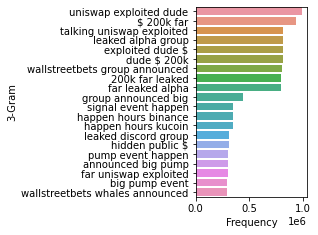

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig,ax = plt.subplots(figsize=(2,3.5))

df = pd.DataFrame(by_count[:20],columns=[f'{3}-Gram','Frequency'])
sns.barplot(
    data=df,
    x = 'Frequency',
    y = f'{3}-Gram',
    ax=ax
)
# t = ax.xaxis.get_offset_text()
# t.set_y(0)

# ax.xaxis.set_label_coords(0.5, -.15)

# plt.tight_layout()

In [25]:
fig.savefig('test.pdf')